#### Romania Electricity Consumption – TS Forecasting (Hourly)
#### Models: SARIMAX, Prophet, Time-Lagged Regression, Chronos-Bolt

In [3]:
import warnings, time, math, sys, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
DATA_PATH = Path("./datasets/electricity_consumption_and_production.csv")

print(f"Python {sys.version.split()[0]}; pandas {pd.__version__}")

TIME_COL_CANDIDATES = ["time", "timestamp", "date", "datetime", "ds"]
TARGET_COL_CANDIDATES = ["consumption", "load", "demand", "y"]

HORIZONS_DAYS = [15, 30, 45]
FREQ = "H"


Python 3.12.1; pandas 2.2.3


### Load data

In [ ]:
assert DATA_PATH.exists(), f"File not found: {DATA_PATH.resolve()}"
df_raw = pd.read_csv(DATA_PATH)

cols_lower = {c.lower(): c for c in df_raw.columns}
time_col = next((cols_lower[c] for c in TIME_COL_CANDIDATES if c in cols_lower), None)
target_col = next((cols_lower[c] for c in TARGET_COL_CANDIDATES if c in cols_lower), None)

if time_col is None:
    raise ValueError(f"Could not find time column among: {TIME_COL_CANDIDATES}. Columns: {list(df_raw.columns)}")
if target_col is None:
    raise ValueError(f"Could not find target column among: {TARGET_COL_CANDIDATES}. Columns: {list(df_raw.columns)}")

df = df_raw[[time_col, target_col]].copy()
df.rename(columns={time_col: "ds", target_col: "y"}, inplace=True)

df["ds"] = pd.to_datetime(df["ds"], utc=False, infer_datetime_format=True)
df = df.sort_values("ds").drop_duplicates("ds")
df.set_index("ds", inplace=True)

full_idx = pd.date_range(df.index.min().ceil("H"), df.index.max().floor("H"), freq=FREQ)
df = df.reindex(full_idx)

missing_ratio = df["y"].isna().mean()
if missing_ratio > 0:
    df["y"] = df["y"].interpolate(method="time").bfill().ffill()

print(df.head(), "\n")
print(df.tail(), "\n")
print("Shape:", df.shape, " Missing ratio after fix:", df["y"].isna().mean())


                          y
2019-01-01 00:00:00  6352.0
2019-01-01 01:00:00  6116.0
2019-01-01 02:00:00  5873.0
2019-01-01 03:00:00  5682.0
2019-01-01 04:00:00  5557.0 

                          y
2025-03-19 19:00:00  8027.0
2025-03-19 20:00:00  7939.0
2025-03-19 21:00:00  7553.0
2025-03-19 22:00:00  6921.0
2025-03-19 23:00:00  6378.0 

Shape: (54480, 1)  Missing ratio after fix: 0.0


### Quick EDA: trend & seasonality

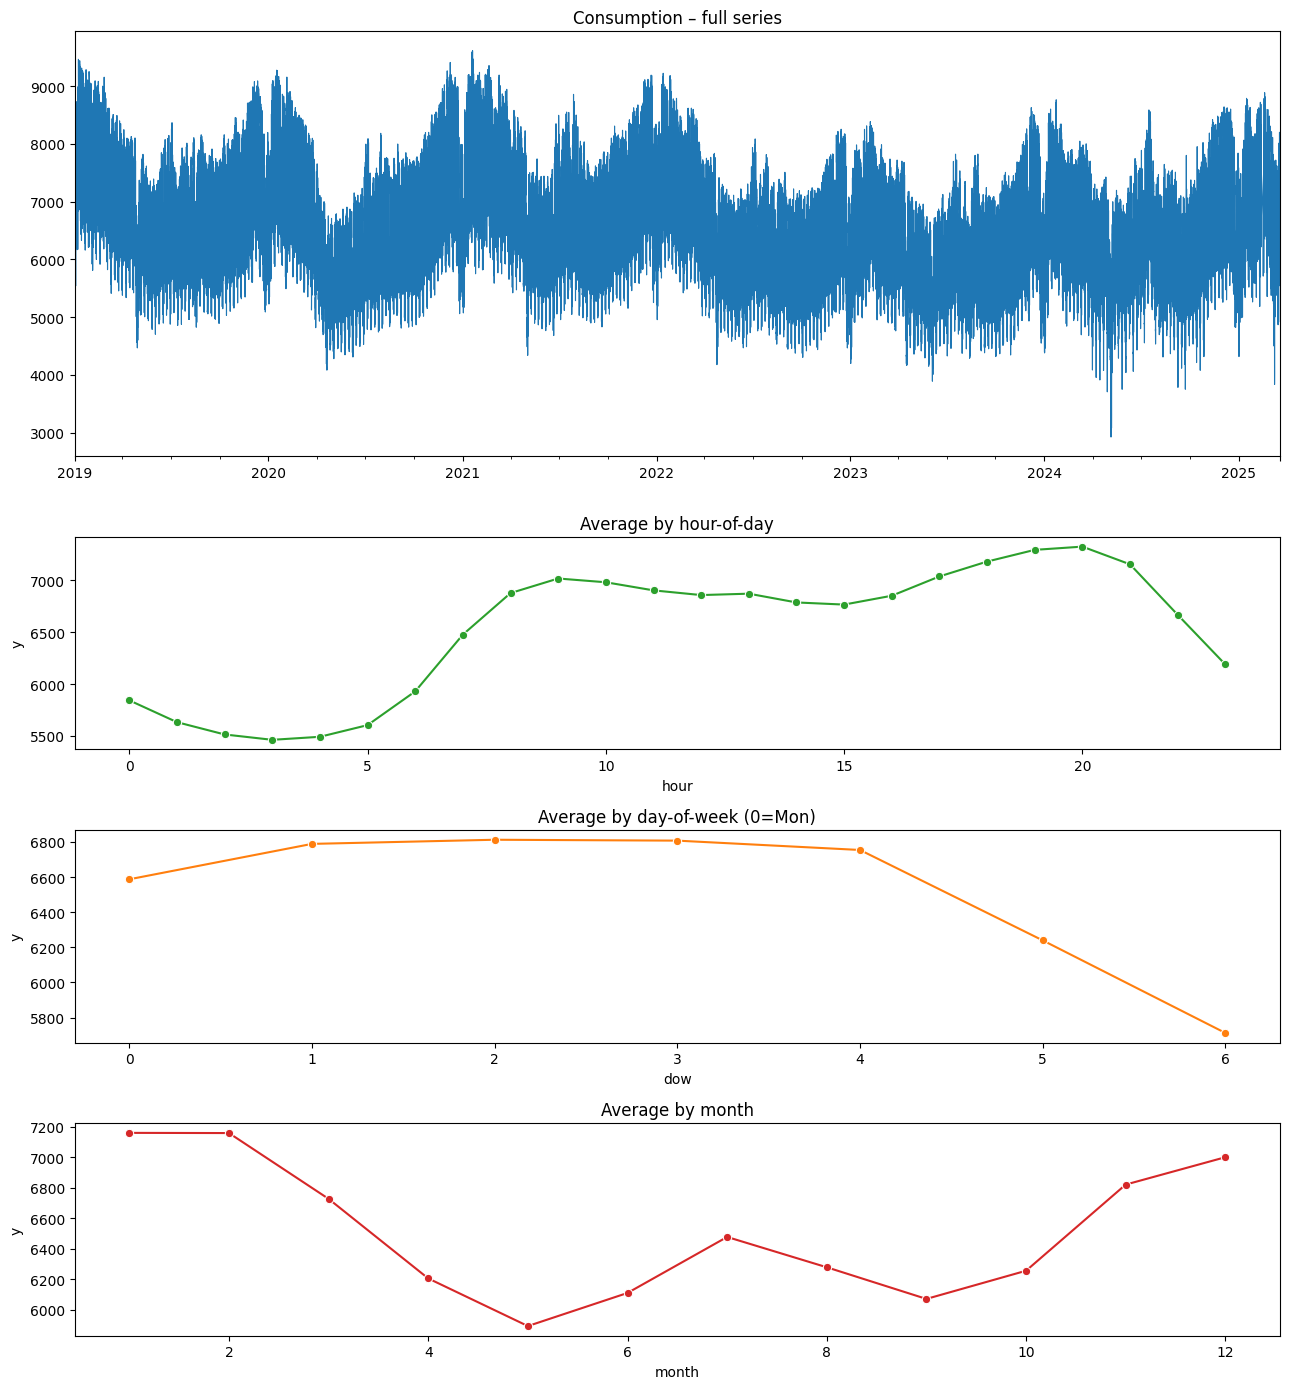

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(13, 14), gridspec_kw={"height_ratios":[2,1,1,1]})
df["y"].plot(ax=axes[0], color="tab:blue", lw=0.8, title="Consumption – full series")

df["hour"] = df.index.hour
sns.lineplot(data=df.groupby("hour")["y"].mean(), ax=axes[1], marker="o", color="tab:green")
axes[1].set_title("Average by hour-of-day")

df["dow"] = df.index.dayofweek
sns.lineplot(data=df.groupby("dow")["y"].mean(), ax=axes[2], marker="o", color="tab:orange")
axes[2].set_title("Average by day-of-week (0=Mon)")

df["month"] = df.index.month
sns.lineplot(data=df.groupby("month")["y"].mean(), ax=axes[3], marker="o", color="tab:red")
axes[3].set_title("Average by month")
plt.tight_layout()
plt.show()

df.drop(columns=["hour","dow","month"], inplace=True)


### Split train / test

In [6]:
max_h = max(HORIZONS_DAYS) * 24
assert len(df) > max_h + 7*24, "Too little data for requested horizons."

train = df.iloc[:-max_h].copy()
test  = df.iloc[-max_h:].copy()

print("Train:", train.index.min(), "→", train.index.max(), "   len:", len(train))
print("Test: ", test.index.min(),  "→", test.index.max(),  "   len:", len(test))


Train: 2019-01-01 00:00:00 → 2025-02-02 23:00:00    len: 53400
Test:  2025-02-03 00:00:00 → 2025-03-19 23:00:00    len: 1080


### Metrics & helpers

In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), eps, None))) * 100

def evaluate_forecast(y_true, y_pred):
    return {"RMSE": rmse(y_true, y_pred), "MAPE_%": mape(y_true, y_pred)}

def plot_forecast(series_df, preds_dict, title):
    plt.figure(figsize=(13,5))
    series_df["y"].plot(label="actual", lw=1.0, color="black")
    for name, pred in preds_dict.items():
        pd.Series(pred, index=pred.index).plot(label=name, lw=1.2)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

### 1. SARIMAX (statsmodels)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_results = {}
sarimax_times = {}

seasonal_period = 24

start_time = time.time()
sarimax_model = SARIMAX(train["y"], order=(1,0,1), seasonal_order=(1,0,1,seasonal_period), enforce_stationarity=False, enforce_invertibility=False)
sarimax_fit = sarimax_model.fit(disp=False)
fit_time = time.time() - start_time

for d in HORIZONS_DAYS:
    h = d*24
    t0 = time.time()
    fc = sarimax_fit.forecast(steps=h)
    infer_time = time.time() - t0
    y_true = test["y"].iloc[:h]
    sarimax_results[h] = {"y_pred": fc, "metrics": evaluate_forecast(y_true, fc)}
    sarimax_times[h] = {"fit_s": fit_time, "infer_s": infer_time}

sarimax_results, sarimax_times


({360: {'y_pred': 2025-02-03 00:00:00    5626.109468
   2025-02-03 01:00:00    5467.359574
   2025-02-03 02:00:00    5381.720487
   2025-02-03 03:00:00    5336.171231
   2025-02-03 04:00:00    5361.453114
                             ...     
   2025-02-17 19:00:00    7237.936071
   2025-02-17 20:00:00    7099.465830
   2025-02-17 21:00:00    6776.421417
   2025-02-17 22:00:00    6322.101259
   2025-02-17 23:00:00    5951.544164
   Freq: h, Name: predicted_mean, Length: 360, dtype: float64,
   'metrics': {'RMSE': 938.65911623603,
    'MAPE_%': np.float64(11.147151140090331)}},
  720: {'y_pred': 2025-02-03 00:00:00    5626.109468
   2025-02-03 01:00:00    5467.359574
   2025-02-03 02:00:00    5381.720487
   2025-02-03 03:00:00    5336.171231
   2025-02-03 04:00:00    5361.453114
                             ...     
   2025-03-04 19:00:00    7001.708547
   2025-03-04 20:00:00    6867.757589
   2025-03-04 21:00:00    6555.256538
   2025-03-04 22:00:00    6115.764283
   2025-03-04 23:00:0

### 2. Prophet (fbprophet/prophet)


In [ ]:
from prophet import Prophet

train.index.name = "ds"
test.index.name = "ds"
train.index = pd.to_datetime(train.index)
test.index  = pd.to_datetime(test.index)

def to_prophet_frame(obj: pd.DataFrame | pd.Series) -> pd.DataFrame:
    if isinstance(obj, pd.Series):
        tmp = obj.rename("y").to_frame()
    else:
        if "y" not in obj.columns:
            raise ValueError("Expected a column 'y' in DataFrame.")
        tmp = obj[["y"]].copy()

    tmp = tmp.reset_index()

    tmp.rename(columns={tmp.columns[0]: "ds"}, inplace=True)

    tmp["ds"] = pd.to_datetime(tmp["ds"], errors="coerce")

    if getattr(tmp["ds"].dt, "tz", None) is not None:
        tmp["ds"] = tmp["ds"].dt.tz_convert(None)

    tmp = tmp.dropna(subset=["ds", "y"])
    return tmp[["ds", "y"]]

def from_prophet_forecast(forecast_df: pd.DataFrame) -> pd.Series:
    out = forecast_df.set_index("ds")["yhat"]
    out.index = pd.DatetimeIndex(out.index)
    return out

prophet_results, prophet_times = {}, {}

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.1,
    seasonality_mode="additive",
)

start_time = time.time()
m.fit(to_prophet_frame(train))
fit_time = time.time() - start_time

for d in HORIZONS_DAYS:
    h = d * 24
    future = m.make_future_dataframe(periods=h, freq=FREQ, include_history=False)
    t0 = time.time()
    fcst = m.predict(future)
    infer_time = time.time() - t0

    y_pred = from_prophet_forecast(fcst)
    y_true = test["y"].iloc[:h]

    prophet_results[h] = {"y_pred": y_pred, "metrics": evaluate_forecast(y_true, y_pred)}
    prophet_times[h] = {"fit_s": fit_time, "infer_s": infer_time}

prophet_results, prophet_times


22:27:53 - cmdstanpy - INFO - Chain [1] start processing
22:28:35 - cmdstanpy - INFO - Chain [1] done processing


({360: {'y_pred': ds
   2025-02-03 00:00:00    5689.413369
   2025-02-03 01:00:00    5521.788818
   2025-02-03 02:00:00    5446.439163
   2025-02-03 03:00:00    5417.999324
   2025-02-03 04:00:00    5469.050132
                             ...     
   2025-02-17 19:00:00    7691.869275
   2025-02-17 20:00:00    7717.036519
   2025-02-17 21:00:00    7489.027648
   2025-02-17 22:00:00    7068.835798
   2025-02-17 23:00:00    6616.460620
   Name: yhat, Length: 360, dtype: float64,
   'metrics': {'RMSE': 667.01826707944,
    'MAPE_%': np.float64(7.444364579204403)}},
  720: {'y_pred': ds
   2025-02-03 00:00:00    5689.413369
   2025-02-03 01:00:00    5521.788818
   2025-02-03 02:00:00    5446.439163
   2025-02-03 03:00:00    5417.999324
   2025-02-03 04:00:00    5469.050132
                             ...     
   2025-03-04 19:00:00    7683.268282
   2025-03-04 20:00:00    7681.813025
   2025-03-04 21:00:00    7430.588164
   2025-03-04 22:00:00    6990.624551
   2025-03-04 23:00:00    652

### 3. Time-Lagged Regression (LinearRegression with lags)

In [ ]:
from sklearn.linear_model import LinearRegression

def make_lagged_frame(y: pd.Series, lags=(1,2,3,24,24*7)):
    X = pd.DataFrame({f"lag_{k}": y.shift(k) for k in lags})
    data = pd.concat([X, y.rename("y")], axis=1).dropna()
    return data

lagged_results = {}
lagged_times = {}

lags = (1,2,3,6,12,24,24*2,24*3,24*7)
lag_train_df = make_lagged_frame(train["y"], lags=lags)
Xtr, ytr = lag_train_df.drop(columns=["y"]), lag_train_df["y"]

start_time = time.time()
lr = LinearRegression(n_jobs=None) if "n_jobs" in LinearRegression().get_params() else LinearRegression()
lr.fit(Xtr, ytr)
fit_time = time.time() - start_time

def recursive_forecast_lr(model, history: pd.Series, horizon: int, lags):
    hist = history.copy()
    preds = []
    for _ in range(horizon):
        row = pd.DataFrame({f"lag_{k}": [hist.iloc[-k]] for k in lags})
        yhat = float(model.predict(row)[0])
        preds.append(yhat)

        next_idx = hist.index[-1] + pd.tseries.frequencies.to_offset(FREQ)
        hist.loc[next_idx] = yhat
    idx = pd.date_range(history.index[-1] + pd.tseries.frequencies.to_offset(FREQ), periods=horizon, freq=FREQ)
    return pd.Series(preds, index=idx)

for d in HORIZONS_DAYS:
    h = d*24
    t0 = time.time()
    y_pred = recursive_forecast_lr(lr, train["y"], h, lags)
    infer_time = time.time() - t0
    y_true = test["y"].iloc[:h]
    lagged_results[h] = {"y_pred": y_pred, "metrics": evaluate_forecast(y_true, y_pred)}
    lagged_times[h]   = {"fit_s": fit_time, "infer_s": infer_time}

lagged_results, lagged_times


({360: {'y_pred': 2025-02-03 00:00:00    5673.885592
   2025-02-03 01:00:00    5605.914189
   2025-02-03 02:00:00    5640.285148
   2025-02-03 03:00:00    5713.896609
   2025-02-03 04:00:00    5789.386401
                             ...     
   2025-02-17 19:00:00    6467.878596
   2025-02-17 20:00:00    6535.851441
   2025-02-17 21:00:00    6662.217888
   2025-02-17 22:00:00    6815.519995
   2025-02-17 23:00:00    6945.865088
   Freq: h, Length: 360, dtype: float64,
   'metrics': {'RMSE': 893.6114978307721,
    'MAPE_%': np.float64(9.509590398498034)}},
  720: {'y_pred': 2025-02-03 00:00:00    5673.885592
   2025-02-03 01:00:00    5605.914189
   2025-02-03 02:00:00    5640.285148
   2025-02-03 03:00:00    5713.896609
   2025-02-03 04:00:00    5789.386401
                             ...     
   2025-03-04 19:00:00    6597.727182
   2025-03-04 20:00:00    6570.426449
   2025-03-04 21:00:00    6541.513779
   2025-03-04 22:00:00    6523.745247
   2025-03-04 23:00:00    6528.139810
   F

### 4. Chronos-Bolt (via Darts wrapper)


In [ ]:
chronos_available = False
chronos_results, chronos_times = {}, {}

try:
    from darts import TimeSeries
    from darts.models import ChronosModel
    chronos_available = True
except Exception as e:
    print("Chronos not available. Install `darts` and `torch` to enable. Error:", repr(e))

if chronos_available:
    from darts.dataprocessing.transformers import Scaler
    ts_train = TimeSeries.from_dataframe(train.reset_index(), time_col="ds", value_cols="y", freq=FREQ)
    scaler = Scaler()
    ts_train_s = scaler.fit_transform(ts_train)

    model_name = "amazon/chronos-bolt-base"
    model = ChronosModel(
        model_name=model_name,
        input_chunk_length=7*24,   
        output_chunk_length=24,    
        n_epochs=1,               
        random_state=42,
        lr=None,                  
        use_gpu=False             
    )

    start_time = time.time()
    model.fit(ts_train_s, verbose=False)
    fit_time = time.time() - start_time

    for d in HORIZONS_DAYS:
        h = d*24
        t0 = time.time()
        fc_s = model.predict(h)
        infer_time = time.time() - t0
        fc = scaler.inverse_transform(fc_s)
        y_pred = pd.Series(fc.values().flatten(), index=pd.date_range(train.index[-1] + pd.tseries.frequencies.to_offset(FREQ), periods=h, freq=FREQ))
        y_true = test["y"].iloc[:h]
        chronos_results[h] = {"y_pred": y_pred, "metrics": evaluate_forecast(y_true, y_pred)}
        chronos_times[h]   = {"fit_s": fit_time, "infer_s": infer_time}

chronos_available, chronos_results, chronos_times


Chronos not available. Install `darts` and `torch` to enable. Error: RuntimeError('operator torchvision::nms does not exist')


(False, {}, {})

### Aggregate metrics & timings


In [15]:
import pprint

def rows_from_results(name, results, times):
    out = []
    for d in HORIZONS_DAYS:
        h = d*24
        if h not in results: 
            continue
        m = results[h]["metrics"]
        t = times.get(h, {})
        out.append({
            "Model": name,
            "Horizon_days": d,
            "RMSE": m["RMSE"],
            "MAPE_%": m["MAPE_%"],
            "Train_time_s": t.get("fit_s", np.nan),
            "Infer_time_s": t.get("infer_s", np.nan),
        })
    return out

rows = []
rows += rows_from_results("SARIMAX", sarimax_results, sarimax_times)
rows += rows_from_results("Prophet", prophet_results, prophet_times)
rows += rows_from_results("LaggedLR", lagged_results, lagged_times)
if chronos_available:
    rows += rows_from_results("ChronosBolt", chronos_results, chronos_times)

metrics_df = pd.DataFrame(rows).sort_values(["Horizon_days","RMSE"]).reset_index(drop=True)
metrics_df


,Model,Horizon_days,RMSE,MAPE_%,Train_time_s,Infer_time_s
0,Prophet,15,667.018267,7.444365,45.914196,0.085005
1,LaggedLR,15,893.611498,9.509590,0.027230,1.428914
2,SARIMAX,15,938.659116,11.147151,69.785783,0.040542
3,Prophet,30,639.605939,7.341544,45.914196,0.141062
4,LaggedLR,30,973.384261,10.768862,0.027230,2.552275
5,SARIMAX,30,979.613945,11.932826,69.785783,0.028609
6,Prophet,45,667.453537,7.905982,45.914196,0.198966
7,SARIMAX,45,892.163068,11.002039,69.785783,0.036948
8,LaggedLR,45,960.839228,11.753842,0.027230,3.757920


### Visualize forecasts for each horizon

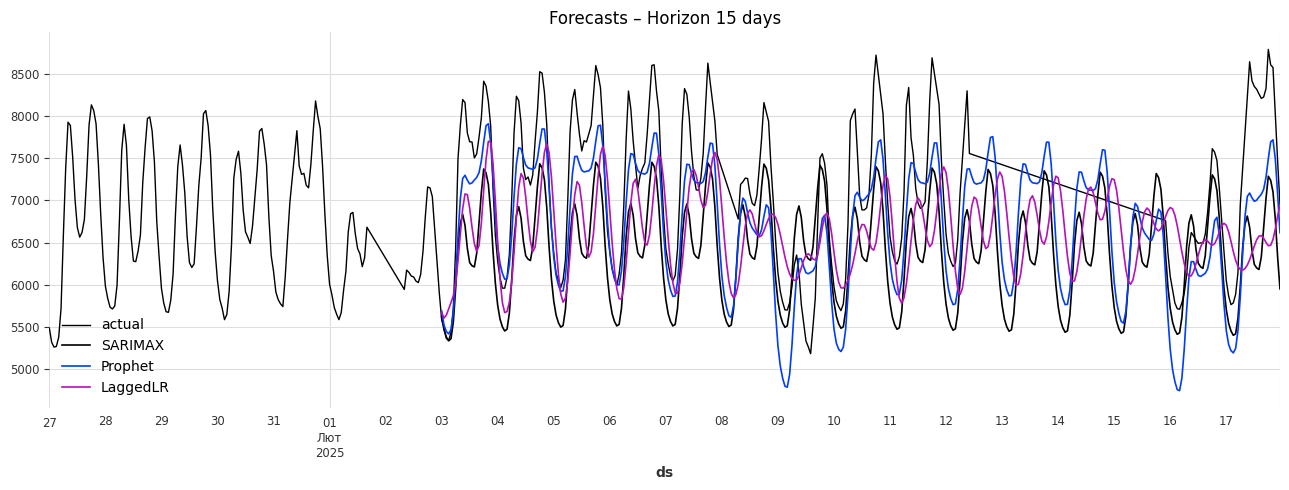

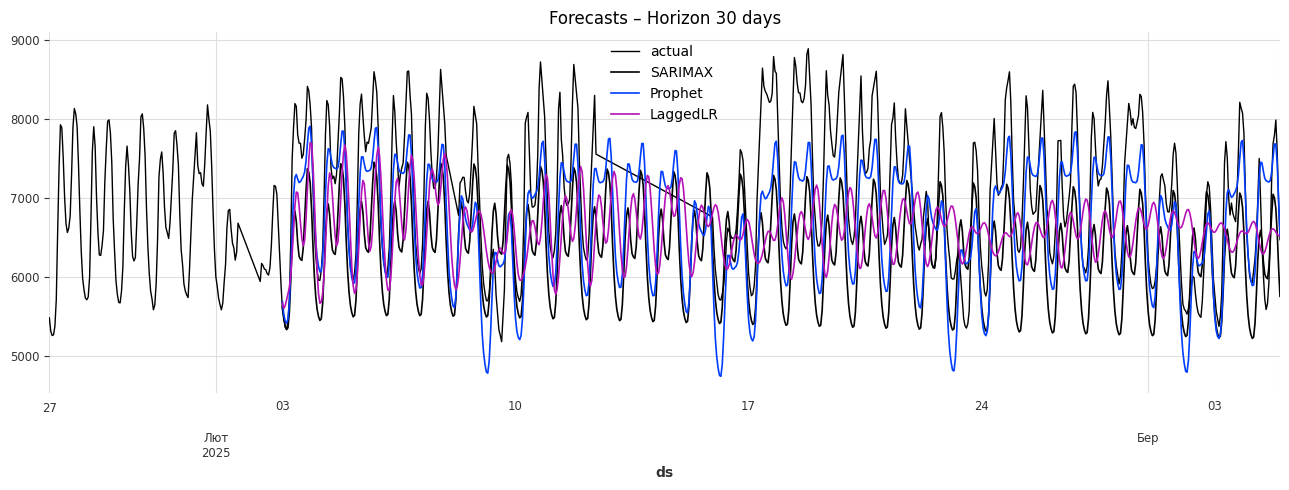

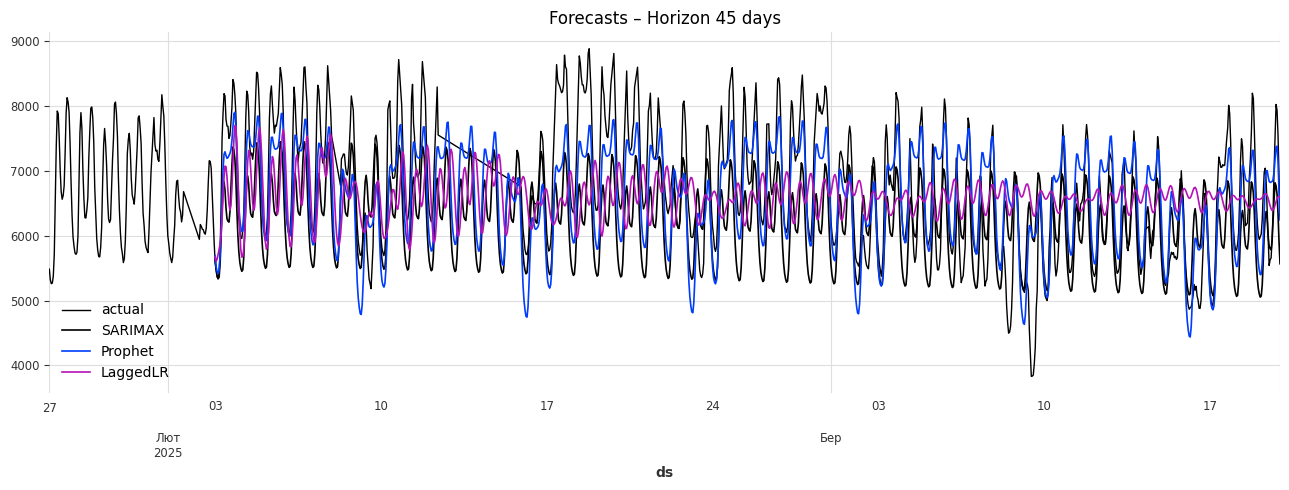

In [17]:

def collect_preds_for_plot(h):
    preds = {
        "SARIMAX": sarimax_results[h]["y_pred"],
        "Prophet": prophet_results[h]["y_pred"],
        "LaggedLR": lagged_results[h]["y_pred"],
    }
    if chronos_available:
        preds["ChronosBolt"] = chronos_results[h]["y_pred"]
    return preds

for d in HORIZONS_DAYS:
    h = d*24
    preds = collect_preds_for_plot(h)
    window = pd.concat([train.tail(7*24), test.iloc[:h]])  # last 7 days of train + forecast horizon
    plot_forecast(window, preds, title=f"Forecasts – Horizon {d} days")



### Conclusion

In [19]:
best_by_h = metrics_df.loc[metrics_df.groupby("Horizon_days")["RMSE"].idxmin(), ["Horizon_days","Model","RMSE","MAPE_%","Train_time_s","Infer_time_s"]]
print("Best model per horizon (by RMSE):")
print(best_by_h.to_string(index=False))

avg = metrics_df.groupby("Model")["RMSE"].mean().sort_values()
print("\nOverall ranking by mean RMSE across horizons:")
print(avg)


Best model per horizon (by RMSE):
 Horizon_days   Model       RMSE   MAPE_%  Train_time_s  Infer_time_s
           15 Prophet 667.018267 7.444365     45.914196      0.085005
           30 Prophet 639.605939 7.341544     45.914196      0.141062
           45 Prophet 667.453537 7.905982     45.914196      0.198966

Overall ranking by mean RMSE across horizons:
Model
Prophet     658.025914
SARIMAX     936.812043
LaggedLR    942.611662
Name: RMSE, dtype: float64
